<a href="https://colab.research.google.com/github/ntolayd/Projects/blob/main/Recommendation_Engines/RBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

reference:

https://github.com/IBM/dl-learning-path-assets/blob/main/unsupervised-deeplearning/notebooks/CollabortiveFilteringUsingRBM.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
import warnings
import pickle
import tensorflow as tf
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [3]:
#data loading
!unzip "/content/gdrive/My Drive/ml-1m.zip"
masked = pd.read_csv('/content/gdrive/MyDrive/masked.csv')
test_set = pd.read_csv('/content/gdrive/MyDrive/test_set.csv')
with open(r'/content/gdrive/MyDrive/masked_idx.pkl', "rb") as input_file:
  masked_idx = pickle.load(input_file)
movies = pd.read_csv("ml-1m/movies.dat", sep='::', engine='python', header=None)
movies.columns = ['movie_id', 'movie_name', 'genre']
ratings = pd.read_csv("ml-1m/ratings.dat", sep='::', engine='python', header=None)
ratings.columns=['user_id', 'movie_id', 'rating','timestamp']

Archive:  /content/gdrive/My Drive/ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [4]:
masked = masked.set_index('user_id')
masked_arr = masked.copy().values

In [5]:
#replacing all nans with 0 and normalizing ratings between 0 and 1
masked_arr[np.isnan(masked_arr)] = 0
masked_arr = masked_arr / 5

In [6]:
#Defining Restricted Bottzmann Machine

#number of unique movies as visible units
visible_units = len(masked.columns)

#Number of hidden units
hidden_units = 256

#initializing biases and weights
visible_bias = tf.Variable(tf.zeros([visible_units], tf.float32))
hidden_bias = tf.Variable(tf.zeros([hidden_units], tf.float32))
weights = tf.Variable(tf.zeros([visible_units, hidden_units], tf.float32))

#feedforward 
def feedforward(inp, weights, hidden_bias):
  hidden_prob = tf.nn.sigmoid(tf.matmul([inp], weights) + hidden_bias) 
  hidden_state = tf.nn.relu(tf.sign(hidden_prob - tf.random.uniform(tf.shape(hidden_prob))))
  return hidden_state

#reconstruction the input layer
def reconstruct(hidden_state, weights, visible_bias):
  visible_prob =  tf.nn.sigmoid(tf.matmul(hidden_state, tf.transpose(weights)) + visible_bias)
  visible_state = tf.nn.relu(tf.sign(visible_prob - tf.random.uniform(tf.shape(visible_prob))))
  return visible_state[0]

In [7]:
#input layer
inp = tf.zeros([visible_units], tf.float32)
#hidden layer
hidden_values = feedforward(inp, weights=weights, hidden_bias=hidden_bias)
#visible output
visible_values = reconstruct(hidden_values, weights=weights, visible_bias=visible_bias)

In [8]:
visible_state = inp

100%|██████████| 15/15 [04:27<00:00, 17.86s/it]


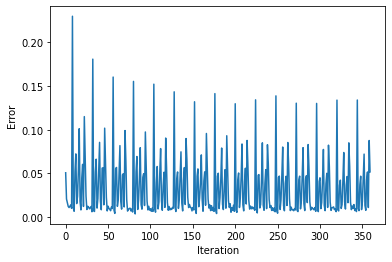

In [9]:
#Training
epochs= 15
batch_size=256
errors = []
final_weights = []
K=1
learning_rate=0.01

training_data = tf.data.Dataset.from_tensor_slices((np.float32(masked_arr))).batch(batch_size)

def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

for epoch in tqdm(range(epochs)):
  batch_number = 0
  for batch_x in training_data:
    for sample in range(len(batch_x)):
      for k in range(K):
        visible_state = batch_x[sample]
        hidden_state= feedforward(visible_state, weights, hidden_bias)
        visible1_state = reconstruct(hidden_state, weights, visible_bias)
        hidden1_state = feedforward(visible1_state, weights, hidden_bias)

        delta_weights = tf.matmul(tf.transpose([visible_state]), hidden_state) - tf.matmul(tf.transpose([visible1_state]), hidden1_state)

        weights = weights + learning_rate * delta_weights
        visible_bias = visible_bias + learning_rate * tf.reduce_mean(visible_state - visible1_state, 0)
        hidden_bias = hidden_bias + learning_rate * tf.reduce_mean(hidden_state - hidden1_state, 0)

        visible_state = visible1_state

      if sample == len(batch_x)-1:
        err = error(batch_x[sample], visible1_state)
        final_weights.append(weights)
        errors.append(err)
    batch_number += 1

plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Iteration')
plt.show()

In [10]:
def make_recommendation(user_id,n):
  user_input = tf.convert_to_tensor(masked_arr[user_id-1],"float32")
  h0 = tf.nn.sigmoid(tf.matmul([user_input], weights) + hidden_bias)
  v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(weights)) + visible_bias)
  scored_movies = movies[movies['movie_id'].isin(masked.columns)]
  scored_movies['Recommedation_Score'] = v1[0] 
  rated_movies = ratings[ratings['user_id'] == user_id]
  return rated_movies.merge(scored_movies, on='movie_id', how='outer').head(n).sort_values(["Recommedation_Score"], ascending=False)


In [11]:
rec = make_recommendation(1,30)['movie_id']

In [12]:
def apk(actual, predicted, k=10):

    if len(actual) == 0:
      return 0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)


    return score / min(len(actual), k)

In [13]:
def apk_user(user_id,k):
  user_avg = masked[masked.index == user_id].mean(axis=1).values[0]
  user_test = test_set[test_set['user_id'] == user_id][['movie_id','rating']]
  user_test = user_test[user_test['rating'] >= user_avg]['movie_id'].values
  rec = make_recommendation(user_id,k)['movie_id']
  return apk(user_test, rec, k)

In [14]:
apk_user(100,30)

0.03352520495377638

In [15]:
mean_apk_enhanced = np.mean([apk_user(i,30) for i in masked.index.unique()])

In [16]:
mean_apk_enhanced

0.07198985892008679